# I. Lý thuyết

1) Tại sao các mô hình deep learning lại chiếm ưu thế hơn so với các mô hình machine learning truyền thống đối với dữ liệu lớn ?

**A. Do mô hình deep learning có thể được thiết kế với kích thước tùy ý nên có khả năng xấp xỉ mọi hàm số. Do đó nó có khả năng biểu diễn tốt và hoạt động hiệu quả trên dữ liệu lớn.**

B. Các mô hình machine learning thường bị overfitting đối với dữ liệu lớn ?

C. Các mô hình deep learning có chi phí huấn luyện tốn kém hơn so với machine learning.

D. Do kiến trúc của mô hình Machine Learning bao gồm nhiều layers xếp chồng.


2) Ý nghĩa của hàm loss function trong mạng neural network là gì ?

A. Là hàm số đánh giá độ chính xác của mô hình.

**B. Mục tiêu của quá trình huấn luyện là tối thiểu hóa hàm loss function bằng thuật toán gradient descent. Giá trị của hàm số này giúp đo lường mức độ khớp của dự báo từ mô hình trên dữ liệu huấn luyện.**

C. Khi loss function giảm thì luôn đảm bảo độ chính xác của mô hình tăng.

D. Là hàm số cần tối đa hóa trong quá trình huấn luyện.


3) Khi huấn luyện trên các bộ dữ liệu bigdata thì chúng ta nên sử dụng phương pháp nào ?

A) Sử dụng gradient descent trên toàn bộ dữ liệu.

B) Sử dụng stochastic gradient descent trên từng điểm dữ liệu.

**C) Mini-batch gradient descent huấn luyện mô hình trên từng tập dữ liệu con có kích thước nhỏ hơn memory CPU/GPU.**

D) Có thể sử dụng stochastic gradient descent hoặc mini-batch gradient descent.


4) Quá trình feed forward và backpropagation thực hiện những gì ?

**A) feed forward tính toán output và loss function, backpropagation tính đạo hàm trên từng layer và cập nhật trọng số.** 

B) feed forward cập nhật trọng số cho mô hình, backpropagation tính toán output và loss function.

C) feed forward tính ra output của mô hình, backpropagation tính toán loss function

D) feed forward được thực hiện sau backpropagation.

5) Tác dụng của batch normalization là gì ?

A) Loại bỏ một tỷ lệ ngẫu nhiên số lượng units tại mỗi layer để tạo thành nhiều kiến trúc kết hợp ngẫu nhiên.

B) Tìm ra các tham số phân phối là trung bình và phương sai trên từng mini-batch.

C) Đồng nhất phân phối xác suất của $z^{[l]}$ trên mỗi layer $l$.

**D) Giảm thiểu ảnh hưởng của input distribution shift nhằm giúp huấn luyện loss function nhanh và ổn định hơn.**

# II. Thực hành

Xuất phát từ mô hình tốt nhất của bạn xây dựng được đối với bài toán phân loại income classification tại bài trước. Bạn hãy thực hiện một số thử nghiệm sau:



##6) Thay đổi hàm loss function, batch size và optimizer.

###Xử lý dữ liệu

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive")
folder_path = "/content/drive/MyDrive/Deep learning K1/2.Data"
os.chdir(folder_path)

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import pandas as pd
import re
import torch.nn as nn
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td
# Set random seed for reproducability
torch.manual_seed(0)

In [ ]:
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
seed = 42 
seed_all(seed)

In [ ]:
#Đọc dữ liệu
d_train = pd.read_csv("train.csv")
d_train.head()

,ID,age,work_type,final_weight,education,total_education_yrs,marital_state,job,status,ethnicity,sex,capital_gain,capital_loss,hrs_per_week,nationality,target_income
0,0,45,Private,175925,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,M,0,0,40,US,0
1,1,23,Private,113601,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,M,0,0,30,US,0
2,2,22,Private,112137,Some-college,10,Never-married,Prof-specialty,Other-relative,Asian-Pac-Islander,F,0,0,20,South,0
3,3,27,Private,153078,Prof-school,15,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,M,0,0,40,US,0
4,4,18,Private,375515,11th,7,Never-married,Sales,Own-child,White,F,0,0,20,US,0


In [ ]:
# normalize string
def str_normalize(s):
    # convert into lowercase and replace multiple spaces into single space
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

In [ ]:
# Encode category and object columns 
def process(df):        
  for col in df.columns:
      if df[col].dtype.name == "object" or df[col].dtype.name == "category":
          df[col] = df[col].apply(str_normalize).astype("category")
  return df
df_all = process(d_train.copy())
IDs=df_all.pop('ID')
label = df_all.pop('target_income')
df_all_one_hot = pd.get_dummies(df_all)

In [ ]:
features = df_all_one_hot.columns.tolist()
label = label.values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_all_one_hot[features].values, # input variable
                                                    label, # output variable
                                                    test_size=0.2, # test dataset proportion
                                                    # stratify=df_all['target_income'], # assign equal proportion of target label in train/test 
                                                    random_state=0) # keep train/test split the same if run again. 
print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
#normalize
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Training Set: 20000, Test Set: 5000 



In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
# Reshape y target into [-1, 1] to fit with Binary Cross Entropy
train_y = torch.Tensor(y_train).view(-1, 1).float()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).view(-1, 1).float()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
#creating data with batch_size
def creatData(batch_size):
    # Create a dataset and loader for the training data and labels
    train_x = torch.Tensor(x_train).float()
    # Reshape y target into [-1, 1] to fit with Binary Cross Entropy
    train_y = torch.Tensor(y_train).view(-1, 1).float()
    train_ds = td.TensorDataset(train_x,train_y)
    train_loader = td.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)

    # Create a dataset and loader for the test data and labels
    test_x = torch.Tensor(x_test).float()
    test_y = torch.Tensor(y_test).view(-1, 1).float()
    test_ds = td.TensorDataset(test_x,test_y)
    test_loader = td.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=1)
    print('Ready to load data')

In [ ]:
# Number of hidden layer nodes
hl1 = 8
hl2 = 4

# Define the neural network
class IncomeCL(nn.Module):
    def __init__(self):
        super(IncomeCL, self).__init__()
        self.fc1 = nn.Linear(len(train_x[1]), hl1)
        self.fc2 = nn.Linear(hl1, hl2)
        self.fc3 = nn.Linear(hl2, 1)
        self.random_state = 42

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Create a model instance from the network
model = IncomeCL()
print(model)

IncomeCL(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        
        #Lan truyền tiến
        #feedforward: calculate y_pred and loss function
        optimizer.zero_grad()
        out = model(data)
        loss = nn.BCELoss()
        output = loss(out, target)
        train_loss += output.item()

        #Lan truyền ngược
        #backpropagate: compute gradient descent and update weights
        output.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.4f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            loss_criteria = nn.BCELoss()
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            #print(out.data)
            predicted = out.data > 0.5
            correct += torch.sum(target==predicted).item()
            #print(target)
            #print(predicted)
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    avg_acc = correct / len(data_loader.dataset)
    
    # return average loss for the epoch
    return avg_loss, avg_acc

###Thay đổi optimizers

In [ ]:
from pandas.core.common import random_state
def train_model(l_r, optim):
  learning_rate = l_r #0.001
  random_state=42
  if optim == 1:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  elif optim == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  elif optim == 3:
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  optimizer.zero_grad()

  # We'll track metrics for each epoch in these arrays
  epoch_nums = []
  training_loss = []
  validation_loss = []
  acc = []

  # Train over 50 epochs
  epochs = 50
  for epoch in range(1, epochs + 1):

      # print the epoch number
      print('Epoch: {}'.format(epoch))
      
      # Feed training data into the model to optimize the weights
      train_loss = train(model, train_loader, optimizer)
      
      # Feed the test data into the model to check its performance
      test_loss, test_acc = test(model, test_loader)
      
      # Log the metrics for this epoch
      epoch_nums.append(epoch)
      training_loss.append(train_loss)
      validation_loss.append(test_loss)
      acc.append(test_acc)
  return (epoch_nums, training_loss, validation_loss, acc)

In [ ]:
def _train_model(l_r, optim, ep):
  learning_rate = l_r #0.001
  random_state=42
  if optim == 1:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  elif optim == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  elif optim == 3:
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  optimizer.zero_grad()

  # We'll track metrics for each epoch in these arrays
  epoch_nums = []
  training_loss = []
  validation_loss = []
  acc = []

  # Train over 50 epochs
  epochs = ep
  for epoch in range(1, epochs + 1):

      # print the epoch number
      print('Epoch: {}'.format(epoch))
      
      # Feed training data into the model to optimize the weights
      train_loss = train(model, train_loader, optimizer)
      
      # Feed the test data into the model to check its performance
      test_loss, test_acc = test(model, test_loader)
      
      # Log the metrics for this epoch
      epoch_nums.append(epoch)
      training_loss.append(train_loss)
      validation_loss.append(test_loss)
      acc.append(test_acc)
  return (epoch_nums, training_loss, validation_loss, acc)

In [ ]:
from matplotlib import pyplot as plt

def _plot(epoch_nums, training_loss, validation_loss):
  plt.plot(epoch_nums, training_loss)
  plt.plot(epoch_nums, validation_loss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch_nums1, training_loss1, validation_loss1, acc1 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.4940
Validation set: Average loss: 0.3840, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.3660
Validation set: Average loss: 0.3395, Accuracy: 4243/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3459
Validation set: Average loss: 0.3298, Accuracy: 4242/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3372
Validation set: Average loss: 0.3250, Accuracy: 4241/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3318
Validation set: Average loss: 0.3220, Accuracy: 4243/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3270
Validation set: Average loss: 0.3202, Accuracy: 4237/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3233
Validation set: Average loss: 0.3187, Accuracy: 4257/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3204
Validation set: Average loss: 0.3161, Accuracy: 4247/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3176
Validation set: Average loss: 0.3153, Accuracy: 4249/5000 (85%)

Epoch: 10
Training 

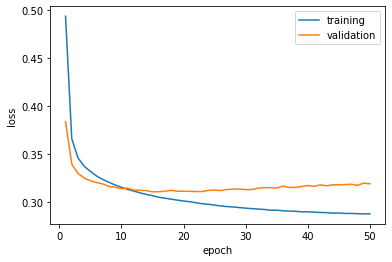

In [ ]:
_plot(epoch_nums1, training_loss1, validation_loss1)

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epoch_nums2, training_loss2, validation_loss2, acc2 = train_model(0.001, 2)

Epoch: 1
Training set: Average loss: 0.6118
Validation set: Average loss: 0.5807, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.5688
Validation set: Average loss: 0.5589, Accuracy: 3811/5000 (76%)

Epoch: 3
Training set: Average loss: 0.5563
Validation set: Average loss: 0.5521, Accuracy: 3811/5000 (76%)

Epoch: 4
Training set: Average loss: 0.5523
Validation set: Average loss: 0.5496, Accuracy: 3811/5000 (76%)

Epoch: 5
Training set: Average loss: 0.5507
Validation set: Average loss: 0.5486, Accuracy: 3811/5000 (76%)

Epoch: 6
Training set: Average loss: 0.5500
Validation set: Average loss: 0.5480, Accuracy: 3811/5000 (76%)

Epoch: 7
Training set: Average loss: 0.5496
Validation set: Average loss: 0.5475, Accuracy: 3811/5000 (76%)

Epoch: 8
Training set: Average loss: 0.5492
Validation set: Average loss: 0.5472, Accuracy: 3811/5000 (76%)

Epoch: 9
Training set: Average loss: 0.5488
Validation set: Average loss: 0.5468, Accuracy: 3811/5000 (76%)

Epoch: 10
Training 

In [ ]:
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
epoch_nums3, training_loss3, validation_loss3, acc3 = train_model(0.001, 3)

Epoch: 1
Training set: Average loss: 0.4483
Validation set: Average loss: 0.3642, Accuracy: 4221/5000 (84%)

Epoch: 2
Training set: Average loss: 0.3563
Validation set: Average loss: 0.3355, Accuracy: 4238/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3415
Validation set: Average loss: 0.3266, Accuracy: 4240/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3340
Validation set: Average loss: 0.3226, Accuracy: 4250/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3281
Validation set: Average loss: 0.3190, Accuracy: 4248/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3252
Validation set: Average loss: 0.3183, Accuracy: 4262/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3221
Validation set: Average loss: 0.3168, Accuracy: 4258/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3198
Validation set: Average loss: 0.3157, Accuracy: 4264/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3176
Validation set: Average loss: 0.3140, Accuracy: 4276/5000 (86%)

Epoch: 10
Training 

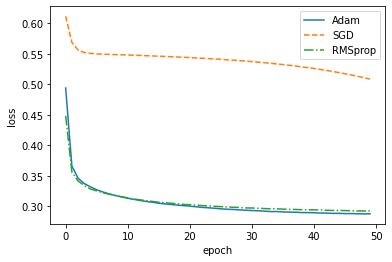

In [ ]:
#Đồ thị hàm loss tương ướng với các thuật toán tối ưu khác nnhau
plt.plot(training_loss1, label = "Adam", linestyle="-")
plt.plot(training_loss2, label = "SGD", linestyle="--")
plt.plot(training_loss3, label = "RMSprop", linestyle="-.")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

Nhận xét: Thuật toán Adam cho hàm loss tốt nhất.

###Thay đổi batch_size

In [ ]:
#Thay đổi batch_size = 64
creatData(64)

Ready to load data


In [ ]:
epoch_nums4, training_loss4, validation_loss4, acc4 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.5421
Validation set: Average loss: 0.4017, Accuracy: 4191/5000 (84%)

Epoch: 2
Training set: Average loss: 0.3726
Validation set: Average loss: 0.3439, Accuracy: 4238/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3460
Validation set: Average loss: 0.3308, Accuracy: 4239/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3364
Validation set: Average loss: 0.3231, Accuracy: 4256/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3298
Validation set: Average loss: 0.3197, Accuracy: 4259/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3249
Validation set: Average loss: 0.3183, Accuracy: 4255/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3212
Validation set: Average loss: 0.3150, Accuracy: 4260/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3181
Validation set: Average loss: 0.3145, Accuracy: 4268/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3155
Validation set: Average loss: 0.3132, Accuracy: 4257/5000 (85%)

Epoch: 10
Training 

In [ ]:
#Thay đổi batch_size = 128
creatData(128)

Ready to load data


In [ ]:
epoch_nums5, training_loss5, validation_loss5, acc5 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.4854
Validation set: Average loss: 0.3875, Accuracy: 4220/5000 (84%)

Epoch: 2
Training set: Average loss: 0.3672
Validation set: Average loss: 0.3415, Accuracy: 4249/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3462
Validation set: Average loss: 0.3322, Accuracy: 4251/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3382
Validation set: Average loss: 0.3271, Accuracy: 4254/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3331
Validation set: Average loss: 0.3234, Accuracy: 4255/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3292
Validation set: Average loss: 0.3203, Accuracy: 4259/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3259
Validation set: Average loss: 0.3193, Accuracy: 4244/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3232
Validation set: Average loss: 0.3184, Accuracy: 4251/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3207
Validation set: Average loss: 0.3167, Accuracy: 4251/5000 (85%)

Epoch: 10
Training 

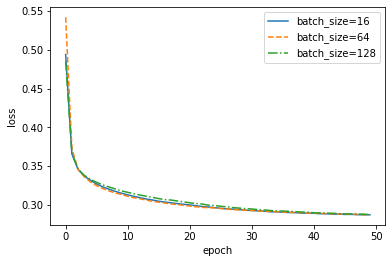

In [ ]:
#Đồ thị hàm loss tương ướng với các thuật toán tối ưu khác nnhau
plt.plot(training_loss1, label = "batch_size=16", linestyle="-")
plt.plot(training_loss4, label = "batch_size=64", linestyle="--")
plt.plot(training_loss5, label = "batch_size=128", linestyle="-.")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

Từ đồ thị ta thấy rằng, Hàm loss cho kết quả như nhau với các batch_size khác nhau.

###Thay đổi hàm loss

In [ ]:
hl1 = 8
hl2 = 4

# Define the neural network
class IncomeCLNet(nn.Module):
    def __init__(self):
        super(IncomeCLNet, self).__init__()
        self.fc1 = nn.Linear(len(train_x[1]), hl1)
        self.fc2 = nn.Linear(hl1, hl2)
        self.fc3 = nn.Linear(hl2, 2)
        self.random_state = 42

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.nn.Softmax()(self.fc3(x))
        return x

# Create a model instance from the network
model2 = IncomeCLNet()
print(model2)

IncomeCLNet(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
def train2(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        
        #Lan truyền tiến
        #feedforward: calculate y_pred and loss function
        optimizer.zero_grad()
        out = model(data)
        #hàm loss khác
        loss = nn.CrossEntropyLoss()
        #print("out:", out)
        #print("target:", target)
        output = loss(out, target)
        train_loss += output.item()

        #Lan truyền ngược
        #backpropagate: compute gradient descent and update weights
        output.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.4f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test2(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)
            # calculate the loss
            loss_criteria = nn.CrossEntropyLoss()
            test_loss += loss_criteria(out, target).item()
            # Calculate the accuracy
            #print(out.data)
            predicted = torch.tensor(out.data[:, 1]>=0.5).float()
            correct += torch.sum(target==predicted).item()
            #print(target)
            #print(predicted)
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    avg_acc = correct / len(data_loader.dataset)
    
    # return average loss for the epoch
    return avg_loss, avg_acc

In [ ]:
from pandas.core.common import random_state
def train_model2(model, l_r, optim):
  learning_rate = l_r #0.001
  random_state=42
  if optim == 1:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  elif optim == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  elif optim == 3:
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  optimizer.zero_grad()

  # We'll track metrics for each epoch in these arrays
  epoch_nums = []
  training_loss = []
  validation_loss = []
  acc = []

  # Train over 50 epochs
  epochs = 50
  for epoch in range(1, epochs + 1):

      # print the epoch number
      print('Epoch: {}'.format(epoch))
      
      # Feed training data into the model to optimize the weights
      train_loss = train2(model2, train_loader, optimizer)
      
      # Feed the test data into the model to check its performance
      test_loss, test_acc = test2(model2, test_loader)
      
      # Log the metrics for this epoch
      epoch_nums.append(epoch)
      training_loss.append(train_loss)
      validation_loss.append(test_loss)
      acc.append(test_acc)
  return (training_loss, validation_loss, acc)

In [ ]:
training_loss10, validation_loss10, acc10 = train_model2(model2, 0.001, 1)

Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Training set: Average loss: 0.4608


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation set: Average loss: 0.4569, Accuracy: 4254/5000 (85%)

Epoch: 2
Training set: Average loss: 0.4572
Validation set: Average loss: 0.4556, Accuracy: 4262/5000 (85%)

Epoch: 3
Training set: Average loss: 0.4552
Validation set: Average loss: 0.4549, Accuracy: 4259/5000 (85%)

Epoch: 4
Training set: Average loss: 0.4537
Validation set: Average loss: 0.4538, Accuracy: 4260/5000 (85%)

Epoch: 5
Training set: Average loss: 0.4528
Validation set: Average loss: 0.4538, Accuracy: 4259/5000 (85%)

Epoch: 6
Training set: Average loss: 0.4517
Validation set: Average loss: 0.4532, Accuracy: 4257/5000 (85%)

Epoch: 7
Training set: Average loss: 0.4509
Validation set: Average loss: 0.4530, Accuracy: 4264/5000 (85%)

Epoch: 8
Training set: Average loss: 0.4499
Validation set: Average loss: 0.4529, Accuracy: 4268/5000 (85%)

Epoch: 9
Training set: Average loss: 0.4493
Validation set: Average loss: 0.4523, Accuracy: 4273/5000 (85%)

Epoch: 10
Training set: Average loss: 0.4486
Validation set: Av

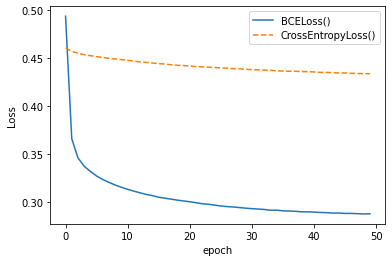

In [ ]:
#Đồ thị hàm loss tương ứng với các hàm loss khác nhau
plt.plot(training_loss1, label = "BCELoss()", linestyle="-")
plt.plot(training_loss10, label = "CrossEntropyLoss()", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

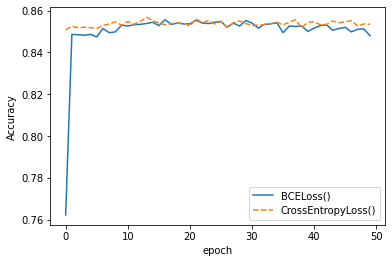

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau
plt.plot(acc1, label = "BCELoss()", linestyle="-")
plt.plot(acc10, label = "CrossEntropyLoss()", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

**Nhận xét**: Hàm loss `BCELoss()` cho kết quả tốt hơn


##7) Thử nghiệm thêm các layers mà bạn đã học được trong bài này vào kiến trúc của mình.


In [ ]:
#Thêm 2 lớp ẩn
# Number of hidden layer nodes
hl1 = 128
hl2 = 64
hl3 = 16
hl4 = 8

# Define the neural network
class IncomeCL(nn.Module):
    def __init__(self):
        super(IncomeCL, self).__init__()
        self.fc1 = nn.Linear(len(train_x[1]), hl1)
        self.fc2 = nn.Linear(hl1, hl2)
        self.fc3 = nn.Linear(hl2, hl3)
        self.fc4 = nn.Linear(hl3, hl4)
        self.fc5 = nn.Linear(hl4, 1)
        self.random_state = 42

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

# Create a model instance from the network
model = IncomeCL()
print(model)

IncomeCL(
  (fc1): Linear(in_features=108, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
epoch_nums6, training_loss6, validation_loss6, acc6 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.4388
Validation set: Average loss: 0.3583, Accuracy: 4211/5000 (84%)

Epoch: 2
Training set: Average loss: 0.3520
Validation set: Average loss: 0.3259, Accuracy: 4253/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3317
Validation set: Average loss: 0.3192, Accuracy: 4261/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3240
Validation set: Average loss: 0.3152, Accuracy: 4274/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3195
Validation set: Average loss: 0.3145, Accuracy: 4264/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3166
Validation set: Average loss: 0.3123, Accuracy: 4273/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3138
Validation set: Average loss: 0.3144, Accuracy: 4270/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3109
Validation set: Average loss: 0.3125, Accuracy: 4275/5000 (86%)

Epoch: 9
Training set: Average loss: 0.3088
Validation set: Average loss: 0.3125, Accuracy: 4264/5000 (85%)

Epoch: 10
Training 

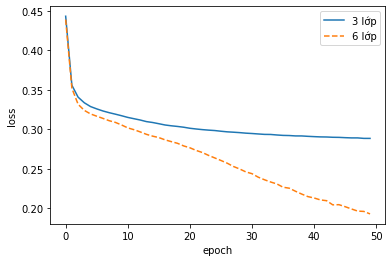

In [ ]:
#Đồ thị hàm loss tương ướng với các kiến trúc khác nhau
plt.plot(training_loss1, label = "3 lớp", linestyle="-")
plt.plot(training_loss6, label = "6 lớp", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

Hàm loss của mô hình 6 lớp có giá trị nhỏ hơn so với mô hình 3 lớp.

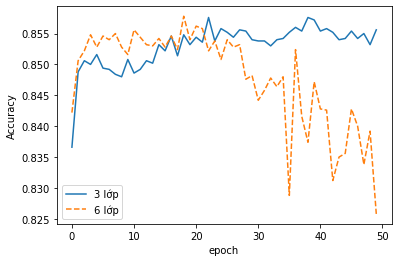

In [ ]:
#Đồ thị accuracy tương ứng với các kiến trúc khác nhau
plt.plot(acc1, label = "3 lớp", linestyle="-")
plt.plot(acc6, label = "6 lớp", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

Với epoch <=20, kiến trúc với 6 lớp cho accuracy cao hơn so với kiến trúc 3 lớp.


Với epoch >20, accuracy của mô hình 3 lớp cao hơn so với mô hình 6 lớp

##8) Thay đổi các khởi tạo trọng số theo các phân phối khác nhau và đánh giá độ chính xác của kết quả huấn luyện.

In [ ]:
"""
import torch.nn as nn        
h_size = 8
# a simple network
rand_net = nn.Sequential(nn.Linear(len(features), h_size),
                         nn.BatchNorm1d(h_size),
                         nn.ReLU(),
                         nn.Linear(h_size, h_size),
                         nn.BatchNorm1d(h_size),
                         nn.ReLU(),
                         nn.Linear(h_size, 1),
                         nn.Sigmoid())
"""

# initialization function, first checks the module type,
# then applies the desired changes to the weights
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight)

# use the modules apply function to recursively apply the initialization
model.apply(init_normal)

IncomeCL(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
epoch_nums7, training_loss7, validation_loss7, acc7 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.6595
Validation set: Average loss: 0.4928, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.4248
Validation set: Average loss: 0.3681, Accuracy: 4217/5000 (84%)

Epoch: 3
Training set: Average loss: 0.3605
Validation set: Average loss: 0.3376, Accuracy: 4253/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3429
Validation set: Average loss: 0.3289, Accuracy: 4254/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3348
Validation set: Average loss: 0.3239, Accuracy: 4260/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3294
Validation set: Average loss: 0.3215, Accuracy: 4251/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3250
Validation set: Average loss: 0.3192, Accuracy: 4260/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3213
Validation set: Average loss: 0.3176, Accuracy: 4261/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3187
Validation set: Average loss: 0.3167, Accuracy: 4262/5000 (85%)

Epoch: 10
Training 

In [ ]:
#General rule for setting weights
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model = IncomeCL()
model.apply(weights_init_uniform_rule)

IncomeCL(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
epoch_nums8, training_loss8, validation_loss8, acc8 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.5458
Validation set: Average loss: 0.4373, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.3917
Validation set: Average loss: 0.3534, Accuracy: 4255/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3526
Validation set: Average loss: 0.3361, Accuracy: 4252/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3397
Validation set: Average loss: 0.3288, Accuracy: 4251/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3321
Validation set: Average loss: 0.3229, Accuracy: 4260/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3267
Validation set: Average loss: 0.3197, Accuracy: 4266/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3226
Validation set: Average loss: 0.3175, Accuracy: 4262/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3194
Validation set: Average loss: 0.3160, Accuracy: 4261/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3163
Validation set: Average loss: 0.3148, Accuracy: 4267/5000 (85%)

Epoch: 10
Training 

In [ ]:
#normal distribution to initialize the weights
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
        values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)


In [ ]:
model = IncomeCL()
model.apply(weights_init_uniform_rule)

IncomeCL(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
epoch_nums9, training_loss9, validation_loss9, acc9 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.4893
Validation set: Average loss: 0.3923, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.3696
Validation set: Average loss: 0.3411, Accuracy: 4251/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3459
Validation set: Average loss: 0.3297, Accuracy: 4259/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3367
Validation set: Average loss: 0.3238, Accuracy: 4253/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3303
Validation set: Average loss: 0.3202, Accuracy: 4262/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3256
Validation set: Average loss: 0.3181, Accuracy: 4264/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3225
Validation set: Average loss: 0.3164, Accuracy: 4264/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3192
Validation set: Average loss: 0.3163, Accuracy: 4249/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3167
Validation set: Average loss: 0.3154, Accuracy: 4262/5000 (85%)

Epoch: 10
Training 

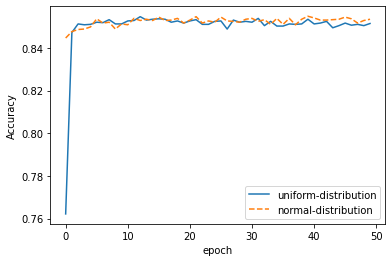

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau
plt.plot(acc8, label = "uniform-distribution", linestyle="-")
plt.plot(acc9, label = "normal-distribution", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau
plt.plot(acc8, label = "uniform-distribution", linestyle="-")
plt.plot(acc9, label = "normal-distribution", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

Cách khởi tạo trọng số theo normal-distribution cho độ chính xác cao hơn

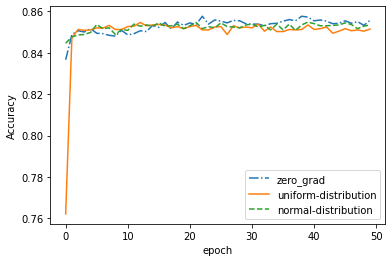

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau
plt.plot(acc1, label = "zero_grad", linestyle="-.")
plt.plot(acc8, label = "uniform-distribution", linestyle="-")
plt.plot(acc9, label = "normal-distribution", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

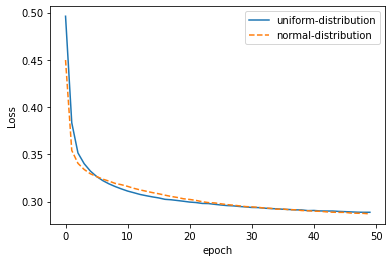

In [ ]:
#Đồ thị hàm loss tương ứng với các cách khởi tạo khác nhau
plt.plot(training_loss8, label = "uniform-distribution", linestyle="-")
plt.plot(training_loss9, label = "normal-distribution", linestyle="--")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Hàm loss của hai cách khởi tạo này cũng cho kết quả như nhau.

In [ ]:
def init_weights(m, init_type = 'xavier'):
    if type(m) == nn.Linear:
      if init_type == 'xavier':
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'normal':
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'he':
        m.bias.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
model = IncomeCL()
model.apply(lambda m: init_weights(m, init_type = 'normal'))

IncomeCL(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
epoch_nums12, training_loss12, validation_loss12, acc12 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.5241
Validation set: Average loss: 0.4492, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.4149
Validation set: Average loss: 0.3778, Accuracy: 4116/5000 (82%)

Epoch: 3
Training set: Average loss: 0.3704
Validation set: Average loss: 0.3551, Accuracy: 4177/5000 (84%)

Epoch: 4
Training set: Average loss: 0.3570
Validation set: Average loss: 0.3471, Accuracy: 4180/5000 (84%)

Epoch: 5
Training set: Average loss: 0.3494
Validation set: Average loss: 0.3419, Accuracy: 4198/5000 (84%)

Epoch: 6
Training set: Average loss: 0.3436
Validation set: Average loss: 0.3378, Accuracy: 4202/5000 (84%)

Epoch: 7
Training set: Average loss: 0.3389
Validation set: Average loss: 0.3348, Accuracy: 4212/5000 (84%)

Epoch: 8
Training set: Average loss: 0.3349
Validation set: Average loss: 0.3320, Accuracy: 4216/5000 (84%)

Epoch: 9
Training set: Average loss: 0.3313
Validation set: Average loss: 0.3299, Accuracy: 4224/5000 (84%)

Epoch: 10
Training 

In [ ]:
model = IncomeCL()
model.apply(lambda m: init_weights(m, init_type = 'xavier'))

IncomeCL(
  (fc1): Linear(in_features=108, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
epoch_nums13, training_loss13, validation_loss13, acc13 = train_model(0.001, 1)

Epoch: 1
Training set: Average loss: 0.4530
Validation set: Average loss: 0.3622, Accuracy: 4221/5000 (84%)

Epoch: 2
Training set: Average loss: 0.3540
Validation set: Average loss: 0.3327, Accuracy: 4241/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3377
Validation set: Average loss: 0.3238, Accuracy: 4246/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3298
Validation set: Average loss: 0.3210, Accuracy: 4257/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3243
Validation set: Average loss: 0.3177, Accuracy: 4251/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3210
Validation set: Average loss: 0.3163, Accuracy: 4261/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3181
Validation set: Average loss: 0.3159, Accuracy: 4260/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3155
Validation set: Average loss: 0.3152, Accuracy: 4258/5000 (85%)

Epoch: 9
Training set: Average loss: 0.3133
Validation set: Average loss: 0.3141, Accuracy: 4264/5000 (85%)

Epoch: 10
Training 

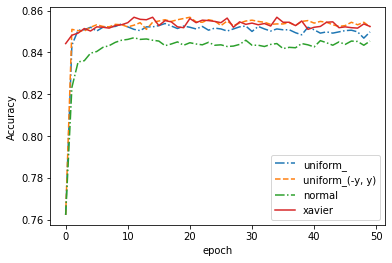

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau 
plt.plot(acc7, label = "uniform_", linestyle="-.")
plt.plot(acc8, label = "uniform_(-y, y)", linestyle="--")
#plt.plot(acc9, label = "normal_", linestyle="-.")
plt.plot(acc12, label = "normal", linestyle="-.")
plt.plot(acc13, label = "xavier", linestyle="-")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

Phương pháp khởi tạo `xavier` và uniform(-y, y) cho độ chính xác cao nhất

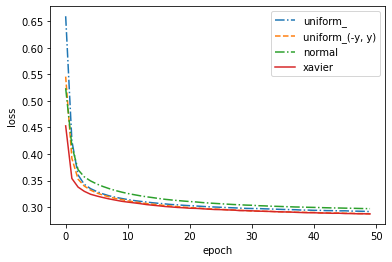

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau 
plt.plot(training_loss7, label = "uniform_", linestyle="-.")
plt.plot(training_loss8, label = "uniform_(-y, y)", linestyle="--")
#plt.plot(acc9, label = "normal_", linestyle="-.")
plt.plot(training_loss12, label = "normal", linestyle="-.")
plt.plot(training_loss13, label = "xavier", linestyle="-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

Phương pháp khởi tạo `xavier` cho hàm loss tốt nhất.

##9) Thiết lập không gian search và tự động hóa tìm kiếm kiến trúc tốt nhất trên optuna.

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 49.9 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 113 kB 43.5 MB/s 
     |████████████████████████████████| 149 kB 48.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d33eea381fd64064ae63642803b277973a12bdac5a247842760ecd500dab5383
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
# Reshape y target into [-1, 1] to fit with Binary Cross Entropy
train_y = torch.Tensor(y_train).view(-1, 1).float()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=16,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).view(-1, 1).float()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=16,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 2, 6)
    layers = []

    in_features = len(features)
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [ ]:
DEVICE = torch.device("cpu")
BATCHSIZE = 16
EPOCHS = 30
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 300
N_VALID_EXAMPLES = BATCHSIZE * 100

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    loss_criteria = nn.BCELoss()
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            # loss = F.nll_loss(output, target)
            loss = loss_criteria(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = torch.tensor(output.data>=0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-16 02:49:45,641] A new study created in memory with name: no-name-db4b60aa-d01f-4955-948f-9470e2f59e07
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-16 02:50:22,892] Trial 0 finished with value: 0.764375 and parameters: {'n_layers': 3, 'n_units_l0': 46, 'dropout_l0': 0.2844120796964156, 'n_units_l1': 49, 'dropout_l1': 0.46774502230335635, 'n_units_l2': 56, 'dropout_l2': 0.36102295799041767, 'optimizer': 'RMSprop', 'lr': 0.07998916891677069}. Best is trial 0 with value: 0.764375.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-16 02:5

Study statistics: 
  Number of finished trials:  27
  Number of pruned trials:  9
  Number of complete trials:  18
Best trial:
  Value:  0.863125
  Params: 
    n_layers: 5
    n_units_l0: 46
    dropout_l0: 0.3504804530374013
    n_units_l1: 95
    dropout_l1: 0.41500069658053385
    n_units_l2: 101
    dropout_l2: 0.23766071796667104
    n_units_l3: 68
    dropout_l3: 0.449088547930642
    n_units_l4: 95
    dropout_l4: 0.4118963192266708
    optimizer: RMSprop
    lr: 0.00076748942379295


In [ ]:
model = define_model(trial)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=108, out_features=46, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3504804530374013, inplace=False)
  (3): Linear(in_features=46, out_features=95, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.41500069658053385, inplace=False)
  (6): Linear(in_features=95, out_features=101, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.23766071796667104, inplace=False)
  (9): Linear(in_features=101, out_features=68, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.449088547930642, inplace=False)
  (12): Linear(in_features=68, out_features=95, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.4118963192266708, inplace=False)
  (15): Linear(in_features=95, out_features=1, bias=True)
  (16): Sigmoid()
)


In [ ]:
def train_model_optuna(model, l_r, optim):
  learning_rate = l_r
  random_state=42
  if optim == 1:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  elif optim == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  elif optim == 3:
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  optimizer.zero_grad()

  # We'll track metrics for each epoch in these arrays
  epoch_nums = []
  training_loss = []
  validation_loss = []
  acc = []

  # Train over 50 epochs
  epochs = 50
  for epoch in range(1, epochs + 1):

      # print the epoch number
      print('Epoch: {}'.format(epoch))
      
      # Feed training data into the model to optimize the weights
      train_loss = train(model, train_loader, optimizer)
      
      # Feed the test data into the model to check its performance
      test_loss, test_acc = test(model, test_loader)
      
      # Log the metrics for this epoch
      epoch_nums.append(epoch)
      training_loss.append(train_loss)
      validation_loss.append(test_loss)
      acc.append(test_acc)
  return (epoch_nums, training_loss, validation_loss, acc)

In [ ]:
epoch_nums11, training_loss11, validation_loss11, acc11 = train_model_optuna(model, 0.00076748942379295, 3)

Epoch: 1
Training set: Average loss: 0.3768
Validation set: Average loss: 0.3360, Accuracy: 4240/5000 (85%)

Epoch: 2
Training set: Average loss: 0.3424
Validation set: Average loss: 0.3112, Accuracy: 4259/5000 (85%)

Epoch: 3
Training set: Average loss: 0.3358
Validation set: Average loss: 0.3161, Accuracy: 4253/5000 (85%)

Epoch: 4
Training set: Average loss: 0.3296
Validation set: Average loss: 0.3110, Accuracy: 4273/5000 (85%)

Epoch: 5
Training set: Average loss: 0.3275
Validation set: Average loss: 0.3130, Accuracy: 4269/5000 (85%)

Epoch: 6
Training set: Average loss: 0.3289
Validation set: Average loss: 0.3142, Accuracy: 4271/5000 (85%)

Epoch: 7
Training set: Average loss: 0.3281
Validation set: Average loss: 0.3133, Accuracy: 4269/5000 (85%)

Epoch: 8
Training set: Average loss: 0.3225
Validation set: Average loss: 0.3204, Accuracy: 4285/5000 (86%)

Epoch: 9
Training set: Average loss: 0.3352
Validation set: Average loss: 0.3112, Accuracy: 4283/5000 (86%)

Epoch: 10
Training 

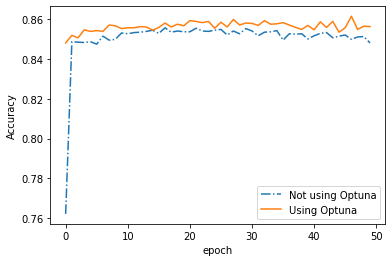

In [ ]:
#Đồ thị accuracy tương ứng với các cách khởi tạo khác nhau
plt.plot(acc1, label = "Not using Optuna", linestyle="-.")
plt.plot(acc11, label = "Using Optuna", linestyle="-")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred, digits=4), '\n')

Evaluation on test dataset
ACCURACY_SCORE:  0.8562
F1_SCORE:  0.7875
CONFUSION_MATRIX:
 [[3562  249]
 [ 470  719]] 

              precision    recall  f1-score   support

           0     0.8834    0.9347    0.9083      3811
           1     0.7428    0.6047    0.6667      1189

    accuracy                         0.8562      5000
   macro avg     0.8131    0.7697    0.7875      5000
weighted avg     0.8500    0.8562    0.8509      5000
 



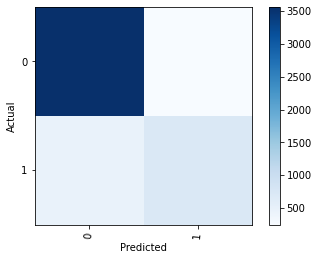

In [ ]:
def _evaluate(model, x_test):
  model.eval()
  x = torch.Tensor(x_test).float()
  predictions = [1 if i>0.5 else 0 for i in model(x).data]
  predictions = torch.tensor(predictions)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()
_evaluate(model, x_test)

**Nhận xét**: Độ chính xác đã được cải thiện với siêu tham số được tìm kiếm dựa trên optuna

##10) Deploy model sử dụng flask ap. Tham khảo [Flaskapp tutorial](https://drive.google.com/file/d/1AZNtzrmnhJ-OBgijWoaAqXbPhJ6xL0Po/view?usp=sharing).

In [ ]:
from PIL import Image
import numpy as np
from flask import Flask, request
import flask
import json

file index.html

In [ ]:
<!DOCTYPE html>
<html>
<body>
    <h3>Income Prediction Form</h3>

<div>
  <form action="/result" method="POST">
    <label for="age">Age</label>
    <input type="text" id="age" name="age">
    <br>
    <label for="w_class">Working Class</label>
    <select id="w_class" name="w_class">
      <option value="0">Federal-gov</option>
      <option value="1">Local-gov</option>
      <option value="2">Never-worked</option>
      <option value="3">Private</option>
      <option value="4">Self-emp-inc</option>
      <option value="5">Self-emp-not-inc</option>
      <option value="6">State-gov</option>
      <option value="7">Without-pay</option>
    </select>
    <br>
    <label for="edu">Education</label>
    <select id="edu" name="edu">
      <option value="0">10th</option>
      <option value="1">11th</option>
      <option value="2">12th</option>
      <option value="3">1st-4th</option>
      <option value="4">5th-6th</option>
      <option value="5">7th-8th</option>
      <option value="6">9th</option>
      <option value="7">Assoc-acdm</option>
      <option value="8">Assoc-voc</option>
      <option value="9">Bachelors</option>
      <option value="10">Doctorate</option>
      <option value="11">HS-grad</option>
      <option value="12">Masters</option>
      <option value="13">Preschool</option>
      <option value="14">Prof-school</option>
      <option value="15">16 - Some-college</option>
    </select>
    <br>
    <label for="martial_stat">Marital Status</label>
    <select id="martial_stat" name="martial_stat">
      <option value="0">divorced</option>
      <option value="1">married</option>
      <option value="2">not married</option>
    </select>
    <br>
    <label for="occup">Occupation</label>
    <select id="occup" name="occup">
      <option value="0">Adm-clerical</option>
      <option value="1">Armed-Forces</option>
      <option value="2">Craft-repair</option>
      <option value="3">Exec-managerial</option>
      <option value="4">Farming-fishing</option>
      <option value="5">Handlers-cleaners</option>
      <option value="6">Machine-op-inspct</option>
      <option value="7">Other-service</option>
      <option value="8">Priv-house-serv</option>
      <option value="9">Prof-specialty</option>
      <option value="10">Protective-serv</option>
      <option value="11">Sales</option>
      <option value="12">Tech-support</option>
      <option value="13">Transport-moving</option>
    </select>
    <br>
    <label for="relation">Relationship</label>
    <select id="relation" name="relation">
      <option value="0">Husband</option>
      <option value="1">Not-in-family</option>
      <option value="2">Other-relative</option>
      <option value="3">Own-child</option>
      <option value="4">Unmarried</option>
      <option value="5">Wife</option>
    </select>
    <br>
    <label for="race">Race</label>
    <select id="race" name="race">
      <option value="0">Amer Indian Eskimo</option>
      <option value="1">Asian Pac Islander</option>
      <option value="2">Black</option>
      <option value="3">Other</option>
      <option value="4">White</option>
    </select>
    <br>
    <label for="gender">Gender</label>
    <select id="gender" name="gender">
      <option value="0">Female</option>
      <option value="1">Male</option>
    </select>
    <br>
    <label for="c_gain">Capital Gain </label>
    <input type="text" id="c_gain" name="c_gain">btw:[0-99999]
    <br>
    <label for="c_loss">Capital Loss </label>
    <input type="text" id="c_loss" name="c_loss">btw:[0-4356]
    <br>
    <label for="hours_per_week">Hours per Week </label>
    <input type="text" id="hours_per_week" name="hours_per_week">btw:[1-99]
    <br>
    <label for="native-country">Native Country</label>
    <select id="native-country" name="native-country">
      <option value="0">Cambodia</option>
      <option value="1">Canada</option>
      <option value="2">China</option>
      <option value="3">Columbia</option>
      <option value="4">Cuba</option>
      <option value="5">Dominican Republic</option>
      <option value="6">Ecuador</option>
      <option value="7">El Salvadorr</option>
      <option value="8">England</option>
      <option value="9">France</option>
      <option value="10">Germany</option>
      <option value="11">Greece</option>
      <option value="12">Guatemala</option>
      <option value="13">Haiti</option>
      <option value="14">Netherlands</option>
      <option value="15">Honduras</option>
      <option value="16">HongKong</option>
      <option value="17">Hungary</option>
      <option value="18">India</option>
      <option value="19">Iran</option>
      <option value="20">Ireland</option>
      <option value="21">Italy</option>
      <option value="22">Jamaica</option>
      <option value="23">Japan</option>
      <option value="24">Laos</option>
      <option value="25">Mexico</option>
      <option value="26">Nicaragua</option>
      <option value="27">Outlying-US(Guam-USVI-etc)</option>
      <option value="28">Peru</option>
      <option value="29">Philippines</option>
      <option value="30">Poland</option>
      <option value="11">Portugal</option>
      <option value="32">Puerto-Rico</option>
      <option value="33">Scotland</option>
      <option value="34">South</option>
      <option value="35">Taiwan</option>
      <option value="36">Thailand</option>
      <option value="37">Trinadad&Tobago</option>
      <option value="38">United States</option>
      <option value="39">Vietnam</option>
      <option value="40">Yugoslavia</option>
    </select>
    <br>
    <input type="submit" value="Submit">
  </form>
</div>
</body>
</html>

In [ ]:
#prediction function
def ValuePredictor(to_predict_list):
    to_predict = np.array(to_predict_list).reshape(1,12)
    loaded_model = pickle.load(open("model.pkl","rb"))
    result = loaded_model.predict(to_predict)
    return result[0]


@app.route('/result',methods = ['POST'])
def result():
    if request.method == 'POST':
        to_predict_list = request.form.to_dict()
        to_predict_list=list(to_predict_list.values())
        to_predict_list = list(map(int, to_predict_list))
        result = ValuePredictor(to_predict_list)
        
        if int(result)==1:
            prediction='Income more than 50K'
        else:
            prediction='Income less that 50K'
            
        return render_template("result.html",prediction=prediction)